# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=1024, nx=2048)

In [7]:
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

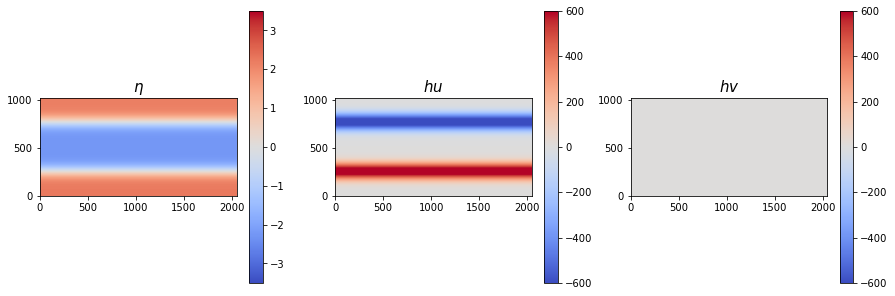

In [8]:
from utils.BasinPlot import *
imshow3(list(doubleJetCase_init.values()), eta_vlim=3.5, huv_vlim=600)

Prepare KL model error

In [9]:
grid_args = {"nx" : doubleJetCase_args["nx"],
             "ny" : doubleJetCase_args["ny"],
             "dx" : doubleJetCase_args["dx"],
             "dy" : doubleJetCase_args["dy"],
             "gpu_ctx" : doubleJetCase_args["gpu_ctx"],
             "gpu_stream": gpu_stream,
             "boundary_conditions" : doubleJetCase_args["boundary_conditions"]
             }

sim_model_error_basis_args = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.015,
                            }

sim_mekl = ModelErrorKL.ModelErrorKL(**grid_args, **sim_model_error_basis_args)

Define DoubleJet sim

In [14]:
sim = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
sim.model_error = sim_mekl

In [15]:
sim.dataAssimilationStep(6*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

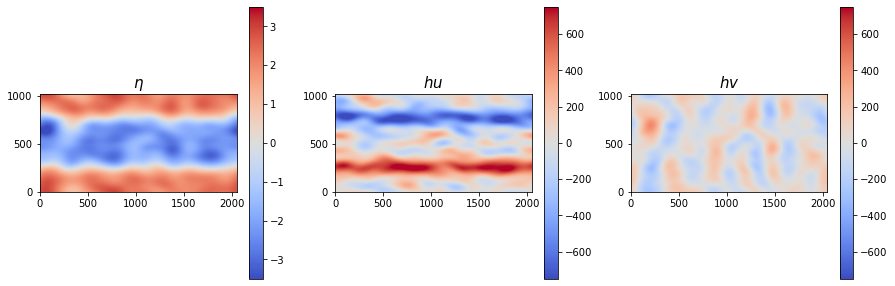

In [16]:
imshowSim(sim, eta_vlim=3.5, huv_vlim=750)

In [17]:
sim.dataAssimilationStep(12*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

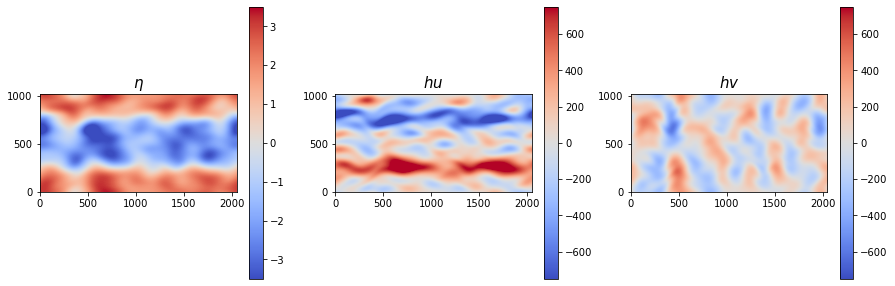

In [18]:
imshowSim(sim, eta_vlim=3.5, huv_vlim=750)

In [19]:
sim.dataAssimilationStep(18*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

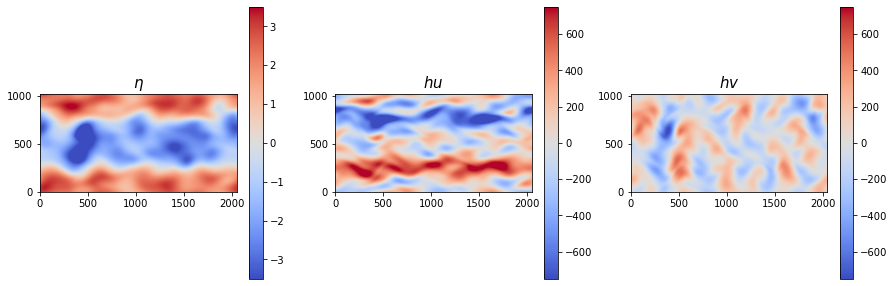

In [20]:
imshowSim(sim, eta_vlim=3.5, huv_vlim=750)

SL-Ensemble of DoubleJets

In [21]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

In [22]:
args = {key: doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
args["gpu_stream"] = gpu_stream

In [23]:
data_args = {"eta" : doubleJetCase_init["eta0"],
             "hu" : doubleJetCase_init["hu0"],
             "hv" : doubleJetCase_init["hv0"],
             "Hi" : doubleJetCase_args["H"]}

In [24]:
sample_args = {"f": doubleJetCase_args["f"], "g": doubleJetCase_args["g"]}

In [25]:
from utils.BasinSL import * 
SL_ensemble = initSLensemble(100, args, data_args, sample_args, 
                    init_model_error_basis_args=None, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

In [26]:
SLstepToObservation(SL_ensemble, 6*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

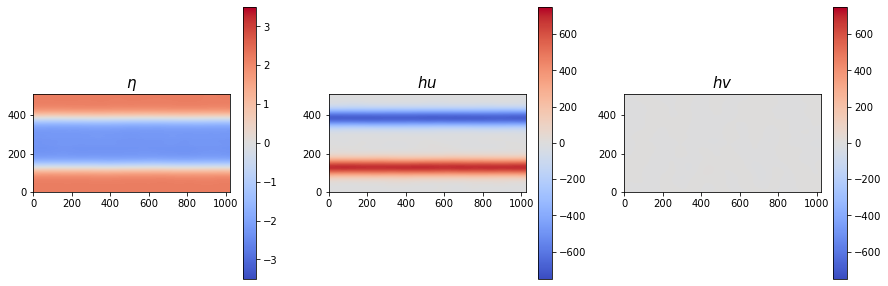

In [27]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

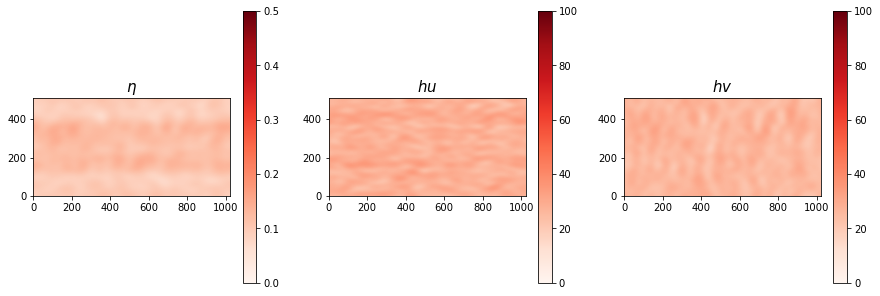

In [28]:
imshow3var(SLestimate(SL_ensemble, np.std), eta_vlim=0.5, huv_vlim=100)

Two-level ensemble

In [29]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init = coarse_doubleJetCase.getInitConditions()

In [30]:
coarse_args = {key: coarse_doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
coarse_args["gpu_stream"] = gpu_stream

In [31]:
coarse_data_args = {"eta" : coarse_doubleJetCase_init["eta0"],
             "hu" : coarse_doubleJetCase_init["hu0"],
             "hv" : coarse_doubleJetCase_init["hv0"],
             "Hi" : coarse_doubleJetCase_args["H"]}

In [32]:
ML_Nes = [100, 50]
args_list = [coarse_args, args]
data_args_list = [coarse_data_args, data_args]

In [33]:
sim_model_error_time_step = 60.0

In [34]:
sim_mekls = []
for l_idx in range(len(args_list)): 
    sim_mekls.append( ModelErrorKL.ModelErrorKL(**args_list[l_idx], **sim_model_error_basis_args) )

In [35]:
## MultiLevel ensemble
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = make_sim(args_list[0], sample_args, init_fields=data_args_list[0])

    sim.model_error = sim_mekls[0]
    sim.model_time_step = sim_model_error_time_step
    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = make_sim(args_list[l_idx], sample_args, init_fields=data_args_list[l_idx])
        sim1 = make_sim(args_list[l_idx-1], sample_args, init_fields=data_args_list[l_idx-1])

        sim0.model_error = sim_mekls[l_idx]
        sim1.model_error = sim_mekls[l_idx-1]

        sim0.model_time_step = sim_model_error_time_step
        sim1.model_time_step = sim_model_error_time_step

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
1


In [36]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [37]:
MLOceanEnsemble.stepToObservation(6*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

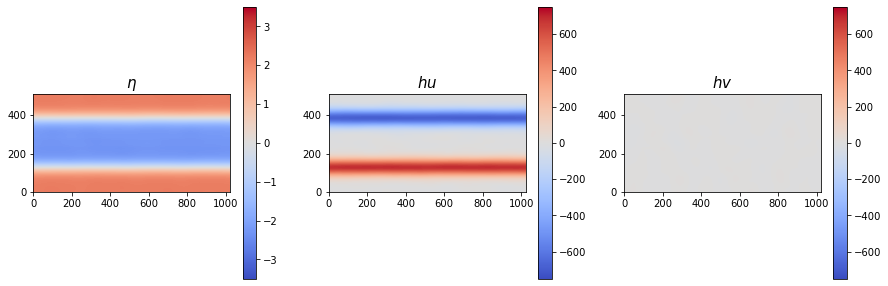

In [38]:
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

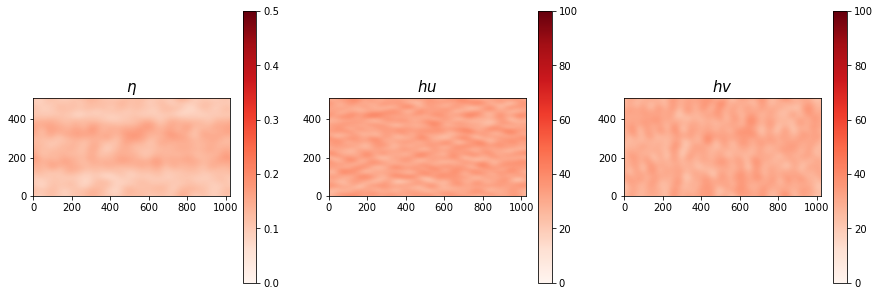

In [39]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

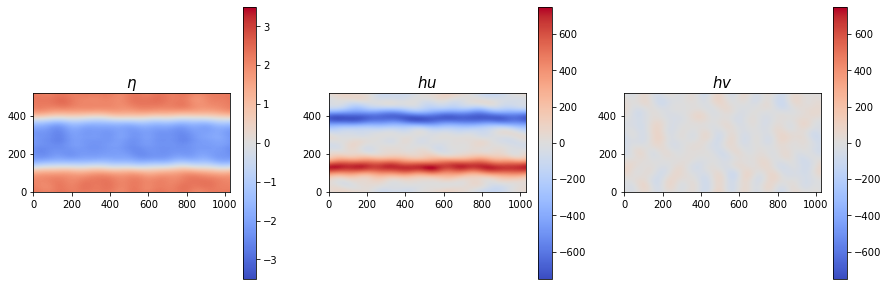

In [40]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][0][0], eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

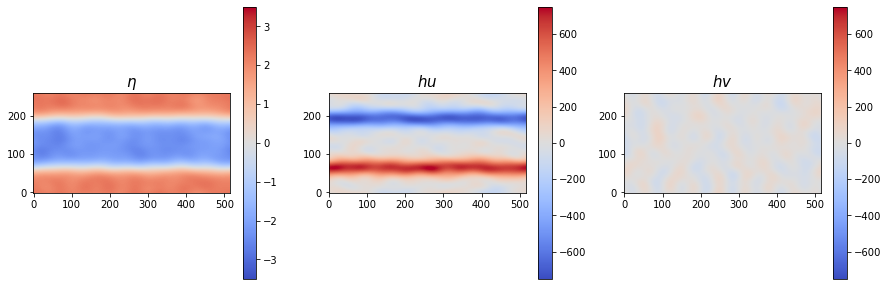

In [41]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][1][0], eta_vlim=3.5, huv_vlim=750)

Generate observations

In [42]:
truth = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)

grid_args = {"nx" : doubleJetCase_args["nx"],
             "ny" : doubleJetCase_args["ny"],
             "dx" : doubleJetCase_args["dx"],
             "dy" : doubleJetCase_args["dy"],
             "gpu_ctx" : doubleJetCase_args["gpu_ctx"],
             "gpu_stream": truth.gpu_stream,
             "boundary_conditions" : doubleJetCase_args["boundary_conditions"]
             }

truth_mekl = ModelErrorKL.ModelErrorKL(**grid_args, **sim_model_error_basis_args)
truth.model_error = truth_mekl

truth.dataAssimilationStep(6*60*60)

In [43]:
xdim = args["nx"]*args["dx"]
ydim = args["ny"]*args["dy"]

In [44]:
xs = np.linspace(0, xdim, 10)
ys = np.linspace(0, ydim, 5)

In [45]:
[obs_xs, obs_ys] = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2).T

In [46]:
R = [0.05, 1.0, 1.0]

In [47]:
from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)


In [48]:
precomp_GC = []
r = 7.5e5
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

In [ ]:
ML_prior = MLOceanEnsemble.download()

In [50]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    print(h)
    Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)
    
    ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                            r=r, obs_var=slice(1,3), relax_factor=0.5, 
                            min_localisation_level=0,
                            precomp_GC=precomp_GC[h])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

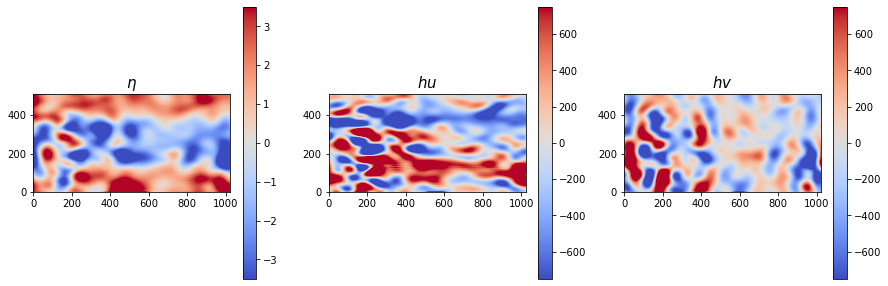

In [51]:
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

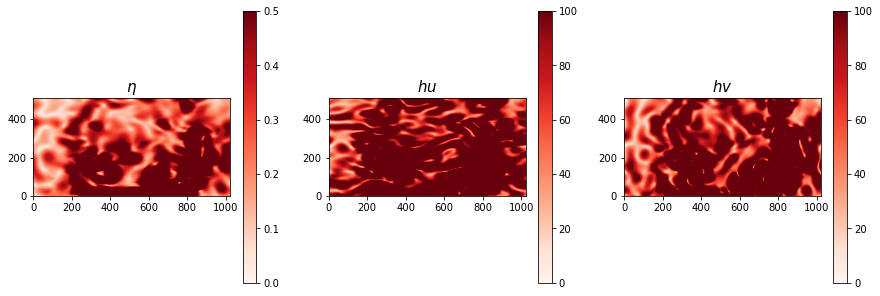

In [52]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)

In [53]:
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(SL_ensemble, obs_x, obs_y)
    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

    SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R=R, obs_var=slice(1,3), 
            relax_factor=0.5, localisation_weights=precomp_GC[h])

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

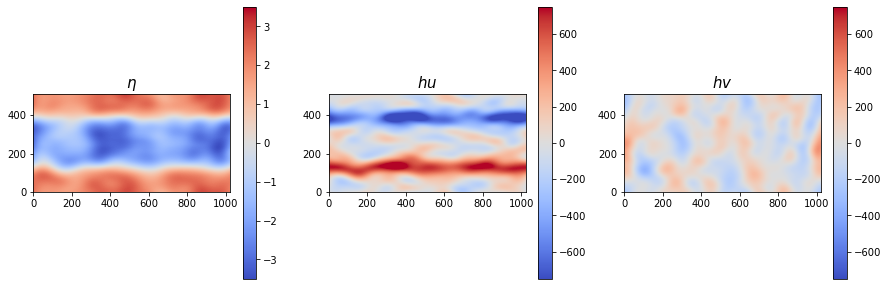

In [54]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

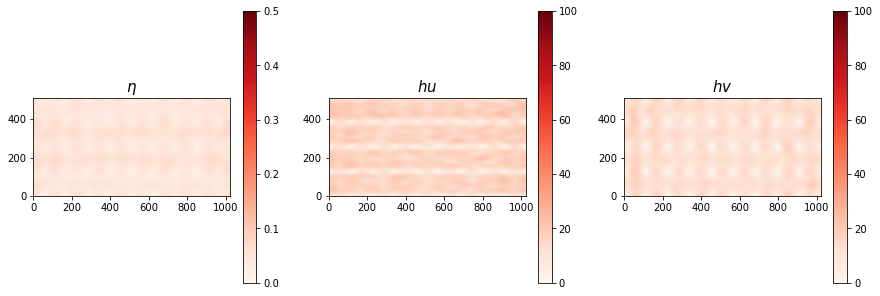

In [55]:
imshow3var(SLestimate(SL_ensemble, np.std), eta_vlim=0.5, huv_vlim=100)